In [1]:
import numpy as np
import pImpactR as impact
from copy import deepcopy as copy
import matplotlib.pyplot as plt

In [2]:
input_fname = 'test.original.in'
# np.set_printoptions(formatter={'float': lambda x: format(x, '1.4E')})
emit = 0
y0 = 8

In [3]:
beam, lattice = impact.readInputFile(input_fname);
ke = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency
offset = y0*0.001
nturn = 2000
betx = 1.892632003629
alfx = 1.37638192047
emitxN = emit*1.0e-6 * 3.0/2.0
n_particles = 1

beam.nCore_y = 1
beam.nCore_z = 1
beam.distribution.emitx = emitxN
beam.n_particles = n_particles

NL_t = 0.45
NL_c = 0.009

reading ImpactZ input file (test.original.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [4]:
beamTmp = copy(beam)
beamTmp.distribution.distribution_type = 'Waterbag'

In [5]:
lattice = [ item for item in lattice if not item.type == 'write_raw_ptcl' ]
lattice.pop(0);
lattice[0].turns=nturn
lattice[1].n_sckick = 100
testLat = [copy(lattice[0])]
testLat[0].turns=0

In [6]:
print(beamTmp.distribution)


 distribution_type: 'Waterbag'
              mode: 'twiss'
              betz: 2324215873134.486 [degree/MeV]
              alfz: 0.0
             emitz: 6.89396745963425e-09 [degree-MeV]
            scalez: 1.0 [1.0]
           scalepz: 1.0 [1.0]
           offsetz: 0.0 [degree]
          offsetpz: 0.0 [MeV]
              betx: 2576.919407166738 [m]
              alfx: 0.0
             emitx: 0.0 [m-rad]
            scalex: 1.0 [1.0]
           scalepx: 1.0 [1.0]
           offsetx: 0.0 [m]
          offsetpx: 0.0 [rad]
              bety: 2576.919407166738 [m]
              alfy: 0.0
             emity: 1.460965201818848e-07 [m-rad]
            scaley: 1.0 [1.0]
           scalepy: 1.0 [1.0]
           offsety: 0.0 [m]
          offsetpy: 0.0 [rad]


In [7]:
impact.writeInputFile(beamTmp,testLat)
impact.run(beamTmp)

input error <- sum(beam.multi_charge.n_particles) not qual to beam.n_particles
  ... enforcing  beam.multi_charge.n_particles[0] to beam.n_particles


0

In [8]:
print(beamTmp.distribution)


 distribution_type: 'Waterbag'
              mode: 'impactdist'
            sigmax: 0.0
           lambdax: 0.0
               mux: 0.0
            scalex: 1.0 [1.0]
           scalepx: 1.0 [1.0]
           offsetx: 0.0 [m]
          offsetpx: 0.0 [rad]
            sigmay: 0.0007108541
           lambday: 0.000129223
               muy: 0.0
            scaley: 1.0 [1.0]
           scalepy: 1.0 [1.0]
           offsety: 0.0 [m]
          offsetpy: 0.0 [rad]
            sigmaz: 2.2092772151898727
           lambdaz: 1.065789e-10
               muz: 0.0
            scalez: 1.0 [1.0]
           scalepz: 1.0 [1.0]
           offsetz: 0.0 [degree]
          offsetpz: 0.0 [MeV]


In [9]:
pDataInit = impact.readParticleData(-111110,ke,mass,freq)
pDataInit[:,2] = pDataInit[:,2] + offset

In [10]:
impact.writeParticleData(pDataInit,ke,mass,freq)
beam.distribution.distribution_type = 'ReadFile'
impact.writeInputFile(beam,lattice)
impact.run(beam)

input error <- sum(beam.multi_charge.n_particles) not qual to beam.n_particles
  ... enforcing  beam.multi_charge.n_particles[0] to beam.n_particles


0

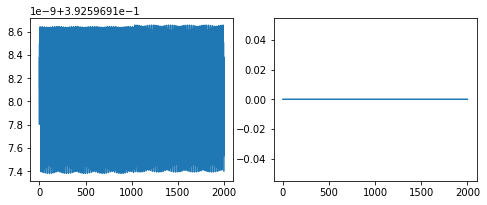

In [11]:
Inv = np.loadtxt('fort.81')
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(Inv[:,1])
plt.subplot(1,2,2)
plt.plot(Inv[:,2])

In [12]:
L=0.0
for item in lattice:
    if 'length' in item.keys():
        L = L + item.length

Y=impact.readRMS('y')        
N = np.argwhere(np.mod(Y.s,L)==0.0)
#N=N[:,0]

In [13]:
M=[]
z = 0.0
for i in range(len(N)):
    if z < Y.s[N[i]]:
        M.append(N[i-1])
        z = Y.s[N[i]]    
M=np.array(M)
print(Y.s[M[:10]])
print(Y.s[M[-1]])

[[ 0.]
 [ 2.]
 [ 4.]
 [ 6.]
 [ 8.]
 [10.]
 [12.]
 [14.]
 [16.]
 [18.]]
[3998.]


In [14]:
Z  = Y.s[M]
Yc = Y.centroid_y[M] 
Pc = Y.centroid_py[M]
Yc = Yc +1j*(betx*Pc+alfx*Yc)
Yc = Yc[:,0]
np.save('Y.single',Yc)
nt = len(Yc)

In [15]:
tune,amp,Yc1 = impact.util.naff(2,Yc)

[0.76098058 0.23901942]
tune= None


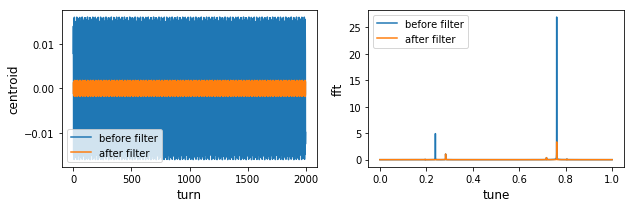

In [16]:
plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plt.plot(np.real(Yc))
plt.plot(np.real(Yc1))
plt.xlabel('turn',fontsize=12);
plt.ylabel('centroid',fontsize=12);
plt.legend(['before filter','after filter'])

plt.subplot(1,2,2)
plt.plot(np.linspace(0,1,nturn),np.abs(np.fft.fft(Yc)))
plt.plot(np.linspace(0,1,nturn),np.abs(np.fft.fft(Yc1)))
plt.xlabel('tune',fontsize=12);
plt.ylabel('fft',fontsize=12);
plt.legend(['before filter','after filter'])

plt.tight_layout()

plt.savefig('single.particle.png',dpi=180,bbox_inches = "tight")
print('tune=',print(tune))